Snippets:
* `(pyvenv)> python3 -m pip freeze > reqs.txt` - wyeksportuj bib pyvenv'a
* `(pyvenv)> python3 -m pip install -r reqs.txt` - zaktualizuj biblioteki pyvenv'a

LOAD `((c x *.jpg; c x *.csv[label_x_ref,*labels_cls]) -> (dx, dy, dl))`

params:
* `data_x_path_regex`     - regex do plików z input'em (obrazów)
* `data_y_path_regex`     - regex do csv-ek z output'em (ground of truth), load merguje je ze sobą
* `data_x_target_shape`   - standaryzacja obrazów
* `label_x_ref`           - kolumna w pandas'ie z hashami do obrazów
* `labels_cls`            - kolumny w pandas'ie z kategoriami klasyfikacji

output:
* `dx: {dy[label_x_ref]: ndarray[c, *data_x_target_shape]]}` - słownik z obrazami hashowany `label_x_ref`
* `dy: pandas.dataframe[label_x_ref,*labels_cls]` - 
* `dl: Tuple[string]` -  lista kategorii po filtracji

In [1]:
import glob
import pandas as pd
import cv2
import numpy as np

data_x_path_regex = r"../ISIC2018_Task3_Validation_Input/*.jpg"
data_y_path_regex = r"../ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
data_x_target_shape = (600, 450, 3)
label_x_ref = 'image'
labels_cls = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# preprocess X data
data_x_target_res = data_x_target_shape[:2]
def data_x_loader(data_x_path):
    x = data_x_path
    x = cv2.imread(x)
    x = cv2.resize(x, data_x_target_res)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2YCrCb)
    return x

def load(data_x_path_regex, data_y_path_regex):
    # read & merge Y data
    data_y_paths = glob.glob(data_y_path_regex)
    print("CSV found:")
    for data_y_path in data_y_paths:
        print(f"    {data_y_path}") 

    assert data_y_paths.__len__() > 0
    dy_full = pd.concat([pd.read_csv(data_y_path) for data_y_path in data_y_paths])

    # todo: filter out nulls
    dy = dy_full

    # filter out samples & labels of fewer than 2 positive
    labels_cls_too_few = dy[labels_cls].loc[:, (dy[labels_cls].sum() < 2)].columns
    for label_cls_too_few in labels_cls_too_few:
        dy = dy.drop(dy[dy.loc[:, label_cls_too_few] == 1].index, axis=0)
    dy = dy.drop(labels_cls_too_few, axis=1)
    dl = [label_cls for label_cls in labels_cls if label_cls not in labels_cls_too_few]

    # read & filter_out by Y & map X data
    data_x_paths = glob.glob(data_x_path_regex)
    map_ref2path_full = {ref: next((dxp for dxp in data_x_paths if ref in dxp), None) for ref in dy_full['image']}
    map_ref2path = {ref: data_x_path for ref, data_x_path in map_ref2path_full.items() if (ref == dy[label_x_ref]).any() and data_x_path is not None}
    dx = {ref: data_x_loader(data_x_path) for ref, data_x_path in map_ref2path.items()}

    # filter out Y entries that dont have X entry
    dy = dy.loc[dy[label_x_ref].isin(map_ref2path.keys())]

    print(
    f"""Read stats:
    # entries ok: {dy.__len__()}
    # excess X: {map_ref2path_full.__len__() - map_ref2path.__len__()}
    # excess Y: {dy_full.__len__() - dy.__len__()}
    # excess L: {labels_cls_too_few.__len__()}  """) # eL- Labels of too little samples

    print("# samples/label:")
    print(dy[dl].sum(axis=0), end="\t\n")
    return dx, dy, dl

dx, dy, dl = load(data_x_path_regex, data_y_path_regex)
dy

CSV found:
    ../ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
Read stats:
    # entries ok: 192
    # excess X: 1
    # excess Y: 1
    # excess L: 1  
# samples/label:
MEL       21.0
NV       123.0
BCC       15.0
AKIEC      8.0
BKL       22.0
VASC       3.0
dtype: float64	


,image,MEL,NV,BCC,AKIEC,BKL,VASC
0,ISIC_0034321,0.0,1.0,0.0,0.0,0.0,0.0
1,ISIC_0034322,0.0,1.0,0.0,0.0,0.0,0.0
2,ISIC_0034323,0.0,0.0,1.0,0.0,0.0,0.0
3,ISIC_0034324,0.0,1.0,0.0,0.0,0.0,0.0
4,ISIC_0034325,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
188,ISIC_0034519,0.0,1.0,0.0,0.0,0.0,0.0
189,ISIC_0034520,0.0,1.0,0.0,0.0,0.0,0.0
190,ISIC_0034521,0.0,0.0,0.0,0.0,1.0,0.0
191,ISIC_0034522,0.0,1.0,0.0,0.0,0.0,0.0


TRAIN TEST SPLIT

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

tts_factor = .2

# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit(np.reshape(dl, (-1, 1)))
# dy_sparse = ohe.inverse_transform()

dyt, dyv = train_test_split(dy, test_size=tts_factor, stratify=dy[dl].to_numpy().argmax(axis=1))


In [3]:
def d2cd(dx, dy_selected, dl): 
    """data to cassification data (dx, dy, dl -> cdx: numpy.ndarray[n, y, x, c], cdy: numpy.ndarray[n, l])"""
    return (np.asarray([dx[x_ref] for x_ref in dy_selected[label_x_ref]]), dy_selected[dl].to_numpy())

cdxt, cdyt = d2cd(dx, dyt, dl)
cdxv, cdyv = d2cd(dx, dyv, dl)

CNN (control case; src: ex s9/DNN/lab4)

% coś slabo mi się uczy ale pewnie danych mao

params:
* `batch_size`
* `model.fit(epochs=)`
* `flatten_res_max` - do jakiego rozmiaru konwolucja ma zredukować obraz (żeby nie narobiło parametrów)

args:
* `(cdx*, cdy*, dl)`

output:
* `model: clf` 
* `history: keras.callbacks.History`

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.preprocessing import image

batch_size = 16
flatten_res_max = 200  

model = models.Sequential()
model.add(layers.Rescaling(1./255, 0., input_shape=data_x_target_shape))

conv_converg  = lambda cr: (((cr[0]-2) // 2), (cr[1]-2)//2)
step_channels = 1
conv_redo = data_x_target_res
while (conv_redo := conv_converg(conv_redo)) and conv_redo[0]*conv_redo[1] > flatten_res_max:
    step_channels += 1

for n_channels in np.linspace(32, 128, step_channels):
    model.add(layers.Conv2D(n_channels, (3,)*2, activation='relu'))
    model.add(layers.MaxPooling2D((2,)*2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(dl), activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 600, 450, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 598, 448, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 299, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 222, 56)      16184     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 111, 56)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 109, 80)      4

In [11]:
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
#       validation_split=.2
)
train_datagen.fit(cdxt) #, augment=True, rounds=rounds)
train_flow = train_datagen.flow(
        cdxt, cdyt,
        batch_size=batch_size,
)

val_datagen = image.ImageDataGenerator(rescale=1./255)
val_datagen.fit(cdxv)
val_flow = val_datagen.flow(
        cdxv, cdyv,
        batch_size=batch_size,
)

# Trening sieci
history = model.fit(
      train_flow,
      # steps_per_epoch=30,
      epochs=10,
      validation_data=val_flow,
      validation_steps=len(val_flow)
) #verbose=2)

Epoch 1/30
10/10 [==============================] - 28s 3s/step - loss: 1.2158 - accuracy: 0.6405 - val_loss: 1.2067 - val_accuracy: 0.6410
Epoch 2/30
10/10 [==============================] - 28s 3s/step - loss: 1.1776 - accuracy: 0.6405 - val_loss: 1.2230 - val_accuracy: 0.6410
Epoch 3/30
10/10 [==============================] - 27s 3s/step - loss: 1.1795 - accuracy: 0.6405 - val_loss: 1.2102 - val_accuracy: 0.6410
Epoch 4/30
10/10 [==============================] - 27s 3s/step - loss: 1.1943 - accuracy: 0.6405 - val_loss: 1.1996 - val_accuracy: 0.6410
Epoch 5/30
10/10 [==============================] - 27s 3s/step - loss: 1.1803 - accuracy: 0.6405 - val_loss: 1.2018 - val_accuracy: 0.6410
Epoch 6/30
10/10 [==============================] - 27s 3s/step - loss: 1.1801 - accuracy: 0.6405 - val_loss: 1.2004 - val_accuracy: 0.6410
Epoch 7/30
10/10 [==============================] - 27s 3s/step - loss: 1.1781 - accuracy: 0.6405 - val_loss: 1.2142 - val_accuracy: 0.6410
Epoch 8/30
10/10 [==

DT CLASSIFIER
% TBD

In [6]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

METRICS
%TBD

In [12]:
from sklearn.metrics import confusion_matrix

# ohe.inverse_transform
confusion_matrix(cdyv.argmax(axis=1), model.predict(cdxv.swapaxes(1,2)).argmax(axis=1))

2/2 [==============================] - 2s 264ms/step


array([[ 0,  4,  0,  0,  0,  0],
       [ 0, 25,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0]], dtype=int64)

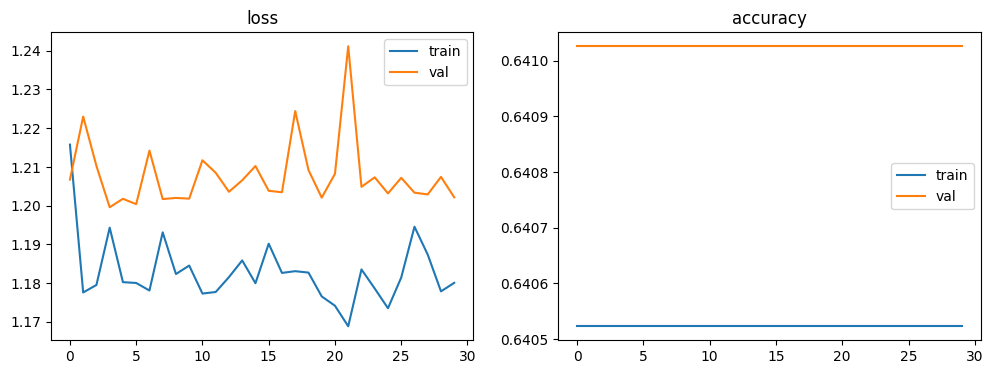

In [13]:
from matplotlib import pyplot as plt

# Porównanie metryk uczenia
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
h = history.history

ax[0].set_title('loss')
ax[0].plot(h['loss'], label='train')
ax[0].plot(h['val_loss'], label='val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(h['accuracy'], label='train')
ax[1].plot(h['val_accuracy'], label='val')
ax[1].legend()

In [25]:
# ohe.fit([[label_cls, lix] for lix, label_cls in enumerate(labels_cls)])
# ohe.fit_transform(labels_cls)
# print(ohe.get_feature_names_out())

# [y for y in dy['image']]
# data_x_paths
# dy.at[8, 'DF'] = dx[1]
# np.where(dy['image'][0] in data_x_paths)
# for a, in map(str.__contains__, dy['image'], data_x_paths):
#     print(a) 
# dy.loc[dy['image'].isin(['ISIC_0034321', ''])]
# map_ref2path.keys()
# dx
# import keras
# sparse_encode([[0, 1], [1, 0]])

# from sklearn.decomposition import sparse_encode
# ohe.inverse_transform(dy[labels_cls].to_numpy())
# ohe.transform(ohe.inverse_transform(dy[labels_cls]))
# dy[labels_cls].loc[:, (dy[labels_cls].sum() < 2)].columns
# dy.loc[dy['DF'] == 1]
# dy.drop
# dy.drop(dy[dy.loc[:, 'DF'] == 1].index, axis=0).__len__()
# dy.loc[dy[['DF']] == 1]
# ("ISIC_0034321" == dy['image']).any()

# for i in range(30):
#     print(i, next(train_flow)[0].shape)
# # train_flow.n
# print(len(train_flow), rounds)
# image.ImageDataGenerator()

# from tensorflow.keras.applications import VGG16
 
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=data_x_target_res)

# conv_base.trainable = False

# # Zintegrowanie sicei VGG16 oraz nowego klasyfikatora
# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.RMSprop(learning_rate=2e-5),
#               metrics=['acc'])

# model.summary()

# model.add(layers.Conv2D(32, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(32, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(64, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(64, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(128, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))
# model.add(layers.Conv2D(128, (3,)*2, activation='relu'))
# model.add(layers.MaxPooling2D((2,)*2))

# history
# for i in range(10):
#     print(cdxt[i, 0, 0, :], cdyt[i])
(model.predict(cdxv.swapaxes(1,2))*100).astype(int)
# cdyt.sum(axis=0)

2/2 [==============================] - 2s 275ms/step


array([[ 98, 100,  59,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 99, 100,  59,   0,  99,   0],
       [ 99, 100,  59,   0,  99,   0],
       [ 98, 100,  58,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 99, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 98, 100,  59,   0,  99,   0],
       [ 99, 100,  60,   0,  99,   0],
       [ 98, 100,  59,   